# Non supervised 16 PF

In [23]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
import math

In [2]:
data = np.genfromtxt('data_semINTMAX.csv', delimiter = ',')

In [3]:
features = data[1: ,0:163]

In [4]:
features.shape

(48832, 163)

In [7]:
features

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 4.,  4.,  4., ...,  4.,  4.,  3.],
       ..., 
       [ 3.,  3.,  3., ...,  3.,  3.,  3.],
       [ 4.,  4.,  3., ...,  3.,  0.,  2.],
       [ 3.,  2.,  3., ...,  2.,  1.,  1.]])

In [8]:
np.random.shuffle(features)

In [10]:
features /= 5

In [23]:
n_components = 163
sample_size = 16386

In [13]:
(n_samples,n_features) = features.shape

# K-Means

In [14]:
ith_k_means = []
for i in range(1,17):
    ith_k_means.append(KMeans(n_clusters=i,verbose=0,n_jobs=-1))

In [15]:
labels_list = []

In [16]:
for i in range(16):
    labels_list.append(ith_k_means[i].fit_predict(features))
    print('end ',i)

end  0
end  1
end  2
end  3
end  4
end  5
end  6
end  7
end  8
end  9
end  10
end  11
end  12
end  13
end  14
end  15


In [17]:
inertia_list = [ith_k_means[i].inertia_ for i in range(16)]

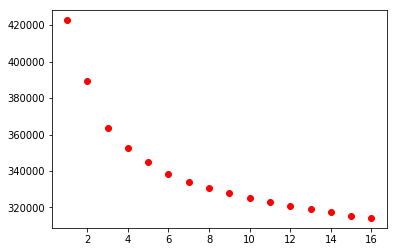

In [18]:
plt.plot(range(1,17), inertia_list, 'ro')
#plt.axis([0, 10, 16000, 18000])
plt.show()

In [19]:
silhouette_list = []

In [24]:
label_sample = np.empty((sample_size))

In [25]:
feat_sample = features[0:sample_size,:]

In [26]:
feat_sample.shape

(16386, 163)

In [27]:
for i in range(1,5):
    label_sample = labels_list[i][0:sample_size]
    silhouette_list.append(metrics.silhouette_score(feat_sample,label_sample,metric='euclidean'))
    print('end ',i)

end  1
end  2
end  3
end  4


In [28]:
silhouette_list

[0.07639898040979877,
 0.085863593477168612,
 0.052062611236410122,
 0.047372652344037855]

# Using new dataset

In [5]:
clean = np.genfromtxt('data_limpo_semINTMAX.csv',delimiter=',')

In [6]:
features = clean[1: ,0:163]

In [7]:
np.random.shuffle(features)
features /= 5

In [63]:
ith_k_means = []
for i in range(1,17):
    ith_k_means.append(KMeans(n_clusters=i,verbose=0,n_jobs=-1))

In [64]:
labels_list = []

In [65]:
for i in range(16):
    labels_list.append(ith_k_means[i].fit_predict(features))
    print('end ',i)

end  0
end  1
end  2
end  3
end  4
end  5
end  6
end  7
end  8
end  9
end  10
end  11
end  12
end  13
end  14
end  15


In [66]:
inertia_list = [ith_k_means[i].inertia_ for i in range(16)]

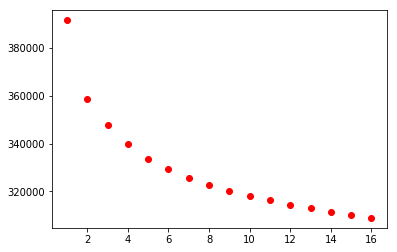

In [67]:
plt.plot(range(1,17), inertia_list, 'ro')
#plt.axis([0, 10, 16000, 18000])
plt.show()

In [68]:
silhouette_list = []

In [69]:
label_sample = np.empty((sample_size))

In [70]:
feat_sample = features[0:sample_size,:]

In [71]:
for i in range(1,5):
    label_sample = labels_list[i][0:sample_size]
    silhouette_list.append(metrics.silhouette_score(feat_sample,label_sample,metric='euclidean'))
    print('end ',i)

end  1
end  2
end  3
end  4


In [72]:
silhouette_list

[0.080561655596033593,
 0.046613284098071486,
 0.041214795721976616,
 0.04028473270377099]

# K Medoids

In [2]:
de# -*- coding: utf-8 -*-
"""K-medoids clustering"""

# Authors: Timo Erkkilä <timo.erkkila@gmail.com>
#          Antti Lehmussola <antti.lehmussola@gmail.com>
# License: BSD 3 clause

import numpy as np
import warnings

from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.utils import check_array, check_random_state
from sklearn.utils.validation import check_is_fitted


class KMedoids(BaseEstimator, ClusterMixin, TransformerMixin):
    """
    k-medoids class.
    Parameters
    ----------
    n_clusters : int, optional, default: 8
        How many medoids. Must be positive.
    distance_metric : string, optional, default: 'euclidean'
        What distance metric to use.
    clustering : {'pam'}, optional, default: 'pam'
        What clustering mode to use.
    init : {'random', 'heuristic'}, optional, default: 'heuristic'
        Specify medoid initialization.
    max_iter : int, optional, default : 300
        Specify the maximum number of iterations when fitting.
    random_state : int, optional, default: None
        Specify random state for the random number generator.
    """

    # Supported clustering methods
    CLUSTERING_METHODS = ['pam']

    # Supported initialization methods
    INIT_METHODS = ['random', 'heuristic']
    

    def __init__(self, n_clusters=8, distance_metric='euclidean',
                 clustering_method='pam', init='heuristic',
                 max_iter=300, random_state=None):

        self.n_clusters = n_clusters

        self.distance_metric = distance_metric

        self.init = init

        self.max_iter = max_iter

        self.clustering_method = clustering_method

        self.random_state = random_state
        
        self.medoid_ics = None

    def _check_init_args(self):

        # Check n_clusters
        if self.n_clusters is None or self.n_clusters <= 0 or \
                not isinstance(self.n_clusters, int):
            raise ValueError("n_clusters has to be nonnegative integer")

        # Check distance_metric
        if callable(self.distance_metric):
            self.distance_func = self.distance_metric
        elif self.distance_metric in PAIRWISE_DISTANCE_FUNCTIONS:
            self.distance_func = \
                PAIRWISE_DISTANCE_FUNCTIONS[self.distance_metric]
        else:
            raise ValueError("distance_metric needs to be " +
                             "callable or one of the " +
                             "following strings: " +
                             "{}".format(PAIRWISE_DISTANCE_FUNCTIONS.keys()) +
                             ". Instead, '{}' ".format(self.distance_metric) +
                             "was given.")

        # Check clustering_method
        if self.clustering_method not in self.CLUSTERING_METHODS:
            raise ValueError("clustering must be one of the following: " +
                             "{}".format(self.CLUSTERING_METHODS))

        # Check init
        if self.init not in self.INIT_METHODS:
            raise ValueError("init needs to be one of " +
                             "the following: " +
                             "{}".format(self.INIT_METHODS))

        # Check random state
        self.random_state_ = check_random_state(self.random_state)

    def fit(self, X, y=None):
        """Fit K-Medoids to the provided data.
        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        Returns
        -------
        self
        """

        self._check_init_args()

        # Check that the array is good and attempt to convert it to
        # Numpy array if possible
        X = self._check_array(X)

        # Apply distance metric to get the distance matrix
        D = self.distance_func(X)

        self.medoid_ics = self._get_initial_medoid_indices(D, self.n_clusters)

        # Old medoids will be stored here for reference
        old_medoid_ics = np.zeros((self.n_clusters,))

        # Continue the algorithm as long as
        # the medoids keep changing and the maximum number
        # of iterations is not exceeded
        self.n_iter_ = 0
        while not np.all(old_medoid_ics == self.medoid_ics) and \
                self.n_iter_ < self.max_iter:

            self.n_iter_ += 1
            
            print("iteration ", self.n_iter_)

            # Keep a copy of the old medoid assignments
            old_medoid_ics = np.copy(self.medoid_ics)

            # Get cluster indices
            cluster_ics = self._get_cluster_ics(D, self.medoid_ics)

            # Update medoids with the new cluster indices
            self._update_medoid_ics_in_place(D, cluster_ics, self.medoid_ics)

        # Expose labels_ which are the assignments of
        # the training data to clusters
        self.labels_ = cluster_ics

        # Expose cluster centers, i.e. medoids
        self.cluster_centers_ = X.take(self.medoid_ics, axis=0)

        # Return self to enable method chaining
        return self

    def _check_array(self, X):

        X = check_array(X)

        # Check that the number of clusters is less than or equal to
        # the number of samples
        if self.n_clusters > X.shape[0]:
            raise ValueError("The number of medoids " +
                             "({}) ".format(self.n_clusters) +
                             "must be larger than the number " +
                             "of samples ({})".format(X.shape[0]))

        return X

    def _get_cluster_ics(self, D, medoid_ics):
        """Returns cluster indices for D and current medoid indices"""

        # Assign data points to clusters based on
        # which cluster assignment yields
        # the smallest distance
        cluster_ics = np.argmin(D[medoid_ics, :], axis=0)

        return cluster_ics

    def _update_medoid_ics_in_place(self, D, cluster_ics, medoid_ics):
        """In-place update of the medoid indices"""

        # Update the medoids for each cluster
        for cluster_idx in range(self.n_clusters):

            if sum(cluster_ics == cluster_idx) == 0:
                warnings.warn("Cluster {} is empty!".format(cluster_idx))
                continue

            # Find current cost that is associated with cluster_idx.
            # Cost is the sum of the distance from the cluster
            # members to the medoid.
            curr_cost = np.sum(D[medoid_ics[cluster_idx],
                                 cluster_ics == cluster_idx])

            # Extract the distance matrix between the data points
            # inside the cluster_idx
            D_in = D[cluster_ics == cluster_idx, :]
            D_in = D_in[:, cluster_ics == cluster_idx]

            # Calculate all costs there exists between all
            # the data points in the cluster_idx
            all_costs = np.sum(D_in, axis=1)

            # Find the index for the smallest cost in cluster_idx
            min_cost_idx = np.argmin(all_costs)

            # find the value of the minimum cost in cluster_idx
            min_cost = all_costs[min_cost_idx]

            # If the minimum cost is smaller than that
            # exhibited by the currently used medoid,
            # we switch to using the new medoid in cluster_idx
            if min_cost < curr_cost:

                # Find data points that belong to cluster_idx,
                # and assign the newly found medoid as the medoid
                # for cluster c
                medoid_ics[cluster_idx] = \
                    np.where(cluster_ics == cluster_idx)[0][min_cost_idx]

    def transform(self, X):
        """Transforms X to cluster-distance space.
        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_samples, n_features)
            Data to transform.
        Returns
        -------
        X_new : array, shape=(n_samples, n_clusters)
            X transformed in the new space.
        """

        check_is_fitted(self, "cluster_centers_")

        # Apply distance metric wrt. cluster centers (medoids),
        # and return these distances
        return self.distance_func(X, Y=self.cluster_centers_)

    def predict(self, X):

        check_is_fitted(self, "cluster_centers_")

        # Check that the array is good and attempt to convert it to
        # Numpy array if possible
        X = check_array(X)

        # Apply distance metric wrt. cluster centers (medoids)
        D = self.distance_func(X, Y=self.cluster_centers_)

        # Assign data points to clusters based on
        # which cluster assignment yields
        # the smallest distance
        labels = np.argmin(D, axis=1)

        return labels

    def inertia(self, X):

        # Map the original X to the distance-space
        Xt = self.transform(X)

        # Define inertia as the sum of the sample-distances
        # to closest cluster centers
        inertia = np.sum(np.min(Xt, axis=1))

        return inertia

    def _get_initial_medoid_indices(self, D, n_clusters):

        if self.init == 'random':  # Random initialization

            # Pick random k medoids as the initial ones.
            medoids = self.random_state_.permutation(D.shape[0])[:n_clusters]

        elif self.init == 'heuristic':  # Initialization by heuristic

            # Pick K first data points that have the smallest sum distance
            # to every other point. These are the initial medoids.
            medoids = list(np.argsort(np.sum(D, axis=1))[:n_clusters])

        else:

            raise ValueError("Initialization not implemented for method: " +
                             "'{}'".format(self.init))

        return medoids
    
    def get_current_medoid_indices(self):
        return self.medoid_ics

# Using the 16PF as input

This data set has no noise or outliers

In [24]:
features = np.genfromtxt('output_limpo_semINTMAX.csv',delimiter=',')

In [4]:
features.shape

(48249, 16)

In [5]:
(n_samples,n_features) = features.shape

For lack of memory reasons, it is not possible to run the K-medoids with all the data

In [7]:
sample_med = n_samples/3

In [7]:
sample_med = int(sample_med)

In [8]:
np.random.shuffle(features)

In [9]:
crop_d = features[0:sample_med,:]

In [10]:
crop_d.shape

(16083, 16)

In [11]:
k_medoids = []

In [12]:
for i in range(1,16):
    k_medoids.append(KMedoids(n_clusters=i),)

In [14]:
for i in range(1,15):
    print('begin',i)
    k_medoids[i].fit(crop_d)

begin 1
iteration  1
iteration  2
begin 2
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
begin 3
iteration  1
iteration  2
begin 4
iteration  1
iteration  2
iteration  3
begin 5
iteration  1
iteration  2
begin 6
iteration  1
iteration  2
begin 7
iteration  1
iteration  2
iteration  3
begin 8
iteration  1
iteration  2
iteration  3
begin 9
iteration  1
iteration  2
begin 10
iteration  1
iteration  2
iteration  3
begin 11
iteration  1
iteration  2
iteration  3
begin 12
iteration  1
iteration  2
iteration  3
begin 13
iteration  1
iteration  2
iteration  3
begin 14
iteration  1
iteration  2
iteration  3
begin 15


IndexError: list index out of range

In [16]:
labels_list = []

In [17]:
for i in range(15):
    labels_list.append(k_medoids[i].predict(crop_d))

In [15]:
silhouette_list = []

In [21]:
for i in range(1,15):
    print('begin',i)
    silhouette_list.append(metrics.silhouette_score(crop_d,labels_list[i],metric='euclidean'))

begin 1
begin 2
begin 3
begin 4
begin 5
begin 6
begin 7
begin 8
begin 9
begin 10
begin 11
begin 12
begin 13
begin 14


In [22]:
silhouette_list

[0.053073196821218194,
 0.075496297560943504,
 0.030781335768721895,
 0.047564407334737629,
 0.048239198491787018,
 0.047216935287281825,
 0.057232541146489249,
 0.043537006479970032,
 0.03730616870485319,
 0.048177365054824964,
 0.041041914500467819,
 0.037215686089995842,
 0.030150876393663581,
 0.027676336480346099]

# More data

Trying with more data to best represent the original

In [6]:
sample_med = n_samples/2

In [7]:
sample_med = int(sample_med)

In [8]:
np.random.shuffle(features)

In [9]:
crop_d = features[0:sample_med,:]

In [10]:
crop_d.shape

(24124, 16)

In [12]:
k_medoids = []

In [13]:
for i in range(2,5):
    k_medoids.append(KMedoids(n_clusters=i))

In [14]:
for i in range(3):
    print('begin',i)
    k_medoids[i].fit(crop_d)

begin 0
iteration  1
iteration  2
iteration  3
begin 1
iteration  1
iteration  2
iteration  3
begin 2
iteration  1
iteration  2
iteration  3


In [30]:
labels_list = []

In [16]:
for i in range(3):
    labels_list.append(k_medoids[i].predict(crop_d))

In [29]:
silhouette_list = []

In [18]:
for i in range(3):
    print('begin',i)
    silhouette_list.append(metrics.silhouette_score(crop_d,labels_list[i],metric='euclidean'))

begin 0
begin 1
begin 2


In [28]:
silhouette_list

[0.0940707328533286, 0.08051435738425429, 0.07490371105878606]

# other metrics

### cosine

In [11]:
crop_d /= np.max(crop_d)

In [12]:
crop_d

array([[ 0.45238095,  0.67765571,  0.23809524, ...,  0.66666667,
         0.45238095,  0.69047619],
       [ 0.73809524,  0.67765571,  0.52380952, ...,  0.57142857,
         0.5       ,  0.5952381 ],
       [ 0.57142857,  0.69597071,  0.66666667, ...,  0.47619048,
         0.38095238,  0.35714286],
       ..., 
       [ 0.61904762,  0.65934071,  0.42857143, ...,  0.45238095,
         0.52380952,  0.45238095],
       [ 0.66666667,  0.58608048,  0.38095238, ...,  0.69047619,
         0.54761905,  0.19047619],
       [ 0.71428571,  0.84249095,  0.66666667, ...,  0.69047619,
         0.85714286,  0.47619048]])

In [13]:
k_medoids = []

In [14]:
for i in range(2,5):
    k_medoids.append(KMedoids(n_clusters=i,distance_metric='cosine'))

In [15]:
for i in range(3):
    print('begin',i)
    k_medoids[i].fit(crop_d)

begin 0
iteration  1
iteration  2
begin 1
iteration  1
iteration  2
iteration  3
begin 2
iteration  1
iteration  2
iteration  3


In [16]:
labels_list = []

In [17]:
for i in range(3):
    labels_list.append(k_medoids[i].predict(crop_d))

In [18]:
silhouette_list = []

In [19]:
for i in range(3):
    print('begin',i)
    silhouette_list.append(metrics.silhouette_score(crop_d,labels_list[i],metric='cosine'))

begin 0
begin 1
begin 2


In [32]:
silhouette_list

[0.16061575, 0.19921601, 0.17753999]

### manhattan

In [61]:
k_medoids = []

In [62]:
for i in range(2,4):
    k_medoids.append(KMedoids(n_clusters=i,distance_metric='manhattan'))

In [63]:
for i in range(2):
    print('begin',i)
    k_medoids[i].fit(crop_d)

begin 0
iteration  1
iteration  2
begin 1
iteration  1
iteration  2
iteration  3
iteration  4


In [64]:
labels_list = []

In [65]:
for i in range(2):
    labels_list.append(k_medoids[i].predict(crop_d))

In [66]:
silhouette_list = []

In [67]:
for i in range(2):
    print('begin',i)
    silhouette_list.append(metrics.silhouette_score(crop_d,labels_list[i],metric='manhattan'))

begin 0
begin 1


In [204]:
silhouette_list

[0.17629505896685452, 0.068458627481225151]

# Checking the medoids

### manhattan metric

In [63]:
k_medoids[0].cluster_centers_

array([[ 0.65116279,  0.62611814,  0.53488372,  0.58139535,  0.46511628,
         0.53488372,  0.48837209,  0.65116279,  0.37209302,  0.51162791,
         0.48837209,  0.44186047,  0.65116279,  0.55813953,  0.46511628,
         0.46511628],
       [ 0.15503876,  0.14055714,  0.13842746,  0.13842746,  0.13289037,
         0.13842746,  0.11627907,  0.13289037,  0.09966777,  0.11627907,
         0.08859358,  0.10520487,  0.14950166,  0.12735327,  0.11074197,
         0.08859358]])

4.3 is approximately the maximum of the input set

In [68]:
print(k_medoids[0].cluster_centers_ * 4.3)

[[ 2.8         2.692308    2.3         2.5         2.          2.3         2.1
   2.8         1.6         2.2         2.1         1.9         2.8         2.4
   2.          2.        ]
 [ 0.66666667  0.60439571  0.5952381   0.5952381   0.57142857  0.5952381
   0.5         0.57142857  0.42857143  0.5         0.38095238  0.45238095
   0.64285714  0.54761905  0.47619048  0.38095238]]


### cosine metric

In [21]:
print(k_medoids[0].cluster_centers_*4.3)

[[ 3.07142857  3.30769207  2.96904762  2.86666667  2.66190476  2.55952381
   2.86666667  2.76428571  1.84285714  2.86666667  1.84285714  1.84285714
   2.96904762  2.04761905  2.76428571  1.84285714]
 [ 2.66190476  2.67765607  1.84285714  2.3547619   1.63809524  2.45714286
   1.53571429  2.45714286  2.04761905  2.45714286  2.3547619   2.76428571
   2.76428571  3.07142857  2.3547619   2.3547619 ]]


In [22]:
print(k_medoids[1].cluster_centers_*4.3)

[[ 3.37857143  3.07142857  2.86666667  3.17380952  2.45714286  2.66190476
   3.17380952  2.96904762  1.63809524  2.45714286  1.43333333  1.84285714
   3.37857143  2.15        2.15        1.63809524]
 [ 2.55952381  2.44139155  1.74047619  2.04761905  1.9452381   1.43333333
   1.43333333  2.55952381  2.25238095  2.86666667  2.04761905  2.55952381
   3.07142857  2.76428571  1.84285714  1.63809524]
 [ 2.25238095  2.20512805  2.25238095  2.15        2.25238095  2.25238095
   1.84285714  2.15        2.15        2.04761905  2.3547619   2.15
   2.25238095  2.15        2.15        2.04761905]]


Future: do feature clustering